## 样本不平衡
### 读取数据

In [1]:
# -*- coding: UTF-8 -*-
"""
此脚本用于展示数据初探
"""

# 保证脚本与Python3兼容
from __future__ import print_function

import os   #读取数据文件
import sys
import datetime
import numpy as np  #科学计算
import matplotlib.pyplot as plt  #画图包
import pandas as pd   #做初步统计分析
from collections import Counter #统计包

import warnings
warnings.filterwarnings("ignore")  #忽略警告
 
%matplotlib inline   

def readData(path):
    """
    使用pandas读取数据
    """
    data = pd.read_csv(path)
    cols = list(data.columns.values)
    return data[cols]
     
 
def visualData(data):
    """
    画直方图，直观了解数据
    """
    data.hist(
        rwidth=0.9, grid=True, figsize=(8, 8), alpha=0.6,bins=10, color="blue")
    plt.show()
 
def sample_class_show(y,savepath='res.png'):
    '''
    绘制饼图，y是标签列表,多分类时候常用
    '''
    target_stats=Counter(y)
    labels=list(target_stats.keys())
    sizes = list(target_stats.values())
    explode=tuple([0.1]*len(target_stats))
    fig,ax  = plt.subplots()
    ax.pie(sizes,explode=explode,labels=labels,shadow=True,autopct='%1.1f%%')
    ax.axis('equal')
    plt.savefig(savepath)
    
if __name__ == "__main__":
    # 设置显示格式
    pd.set_option('display.width', 1000)
    homePath = os.path.dirname(os.path.abspath('__file__'))
    # Windows下的存储路径与Linux并不相同
    if os.name == "nt":
        dataPath = "%s\\train.csv" % homePath
    else:
        dataPath = "%s/train.csv" % homePath
    train = readData(dataPath)
    #train = train.drop_duplicates()

    if os.name == "nt":
        dataPath = "%s\\test.csv" % homePath
    else:
        dataPath = "%s/test.csv" % homePath
    test = readData(dataPath)
    
    print(train.columns) #显示各个字段

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype='object')


####  查看数据列类型和统计信息
从下面数据个数也可以看出哪些列有缺失的，Age，Embarked，Cabin都少于891个。
训练数据中总共有891名乘客，但是很不幸，我们有些属性的数据不全，比如说：
Age（年龄）属性只有714名乘客有记录，
Cabin（客舱）更是只有204名乘客是已知的

In [3]:
print(train[features].info())
    # 查看总体统计信息


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass      891 non-null int64
Parch       891 non-null int64
Sex         891 non-null object
Fare        891 non-null float64
Ticket      891 non-null object
Cabin       204 non-null object
Name        891 non-null object
SibSp       891 non-null int64
Age         714 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB
None


#### 查看总体数据统计信息
这里注意describe只显示了数值型数据，其它数据是无法显示

           Pclass       Parch        Fare       SibSp         Age
count  891.000000  891.000000  891.000000  891.000000  714.000000
mean     2.308642    0.381594   32.204208    0.523008   29.699118
std      0.836071    0.806057   49.693429    1.102743   14.526497
min      1.000000    0.000000    0.000000    0.000000    0.420000
25%      2.000000    0.000000    7.910400    0.000000   20.125000
50%      3.000000    0.000000   14.454200    0.000000   28.000000
75%      3.000000    0.000000   31.000000    1.000000   38.000000
max      3.000000    6.000000  512.329200    8.000000   80.000000
0    549
1    342
Name: Survived, dtype: int64


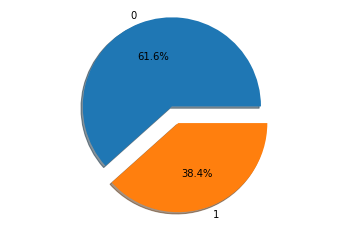

In [4]:
print(train[features].describe())
    
print(train[target].value_counts())
    #可视化
sample_class_show(train[target],savepath='label_distribution.png')

In [10]:
#清洗数据
train.drop(["Cabin","Name","Ticket"],axis=1,inplace=True)
train["Age"] = train["Age"].fillna(train["Age"].mean())

train["Sex"] = (train["Sex"]=="male").astype("int")
labels = train["Embarked"].unique().tolist()
train["Embarked"] = train["Embarked"].apply(lambda x: labels.index(x))

train.fillna(0,inplace=True)

#### 可以看到大概38.4%的人获救了，2/3等舱的人数比1等舱要多，平均乘客年龄大概是29.7岁，最大80岁
这些只是简单统计预览，初步看，接下来是数据清洗和可视化分析，看每个特征和目标之间的关系

### 类别不平衡问题
类别平衡指分类样例不同类别的训练样例数目差别不大。当差别很大时，为类别不平衡。当类别不平衡的时候，例如正反比为 9:1，学习器将所有样本判别为正例的正确率都能达到 0.9。这时候，我们就需要使用 “再缩放”、“欠采样”、“过采样”、“阈值移动” 等方法。

以Titanic的数据为例，这时候存活为1可以是正样本，为0的为负样本，正负比342/549 ，当然相对还是差别不大的

样本不平衡的解决方法主要有两个思路，一个是改变模型，让其对较少的类别较敏感，增大样本数较少类别的样本的权重，当这样的样本被误分时，其损失值要乘上相应的权重，从而让分类器更加关注这一类数目较少的样本。比如逻辑回归，可以调整阈值，让其对少的类更敏感。二是改变训练集合，用过采样(over sampling，如SMOTE等)和欠采样(under sampling)的方式调整训练集的平衡。 

Counter({0: 549, 1: 342})


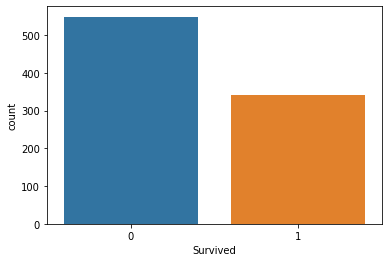

In [5]:
import seaborn as sns 
sns.countplot(x='Survived',data=train) #对不同值的 'Survived' 进行计数并绘图
from collections import Counter
# 查看样本类别分布， 
print(Counter(train[target]))

#### 再缩放

从一般的回归模型来看，样本X通过建立的模型（1），而得出估计值y，其实是个概率，一般我们假设正例和负例是对等的，比如逻辑回归得出是1的概率大于0.5，那么就预测是1，即判断为正例。

$y=\omega^TX+b$   （1）

那么这个y实际是正例的可能性，那么y/(1-y)就是正例可能性和负例可能性的比值，阈值设为0.5就是分类器认为正例可能性和负例可能性比为1，即可能性是一样的：

$\cfrac {y}{1-y}  \gt 1 $  则预测为正例（2）

然而，当训练集中正、反例的数目不同时，令$\large m^+$表示正例数目，$\large m^-$表示反例数目，则观测几率是$\large m^+/m^-$，由于我们通常假设训练集是真实样本总体的无偏估计，因此观测几率就代表了真实几率。于是只要分类器的预测几率高于观测几率就应判定为正例，即


$\cfrac {y}{1-y}  \gt \cfrac {m^+}{m^-}$  则预测为正例（3）

但是，我们的分类器是基于式(2)进行比较决策，因此，需对其预测值进行调整，使其基于式(2)决策时，实际上是在执行式(3)，可以在不等式（3）两边同乘$\cfrac {m^-}{m^+}$，  

$\cfrac {y}{1-y} \cfrac {m^-}{m^+}  \gt \cfrac {m^+}{m^-} \cfrac {m^-}{m^+}$


只需要令  $  {\cfrac {z,}{1-z,}} = { \cfrac {y}{1-y} \times \cfrac {m^-}{m^+}}$

那么最后就是使用
$  {\cfrac {z,}{1-z,}>1} 则预测为正例$ （4）

这个就是类不平衡的一个决策：再缩放（rescaling）。
这个可以形象的看为是对易错题或难题放宽要求，改的松点。就像高考一样，让新疆或是少数民族等地区的本科线设低点，从而加大那个地区人的入取概率。
再缩放的思想虽简单，但实际操作却不平凡，主要是因为“训练集是真实样本总体的无偏采样”这个假设往往并不成立，也就是说，我们未必能有效地基于训练集观测几率来推断出真实几率，而且如果是多分类问题就不好设置了。

#### 欠采样（undersampling）
欠采样比较简单，就是减少进入训练的多数类的样本，可以随机下采样，但是容易丢失一些特征信息，也可以聚类后再按抽取各类的特征的代表来下采样，会比较合理点，但下采样都会丢失少数类样本的信息，开销小，也容易实现。
##### 原型生成(prototype generation)
给定数据集S, 原型生成算法将生成一个子集S’, 其中|S’| < |S|, 但是子集并非来自于原始数据集. 意思就是说: 原型生成方法将减少数据集的样本数量, 剩下的样本是由原始数据集生成的, 而不是直接来源于原始数据集.

ClusterCentroids函数实现了上述功能: 每一个类别的样本都会用K-Means算法的中心点来进行合成, 而不是随机从原始样本进行抽取.
 

In [13]:
#原型生成
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)
X = train[list(set(features)-set(["Cabin","Name","Ticket"]))]
y = train[target]
X_resampled, y_resampled = cc.fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))
 

[(0, 342), (1, 342)]


##### 原型选择(prototype selection)
与原型生成不同的是, 原型选择算法是直接从原始数据集中进行抽取. 抽取的方法大概可以分为两类: (i) 可控的下采样技术(the controlled under-sampling techniques) ; (ii) the cleaning under-sampling techniques( 清洗的下采样技术). 第一类的方法可以由用户指定下采样抽取的子集中样本的数量; 第二类方法则不接受这种用户的干预. 

In [29]:
#原型选择（prototype selection）
#Controlled under-sampling techniques
#RandomUnderSampler函数是一种快速并十分简单的方式来平衡各个类别的数据: 随机选取数据的子集.

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X, y)

print(sorted(Counter(y_resampled).items())) 
#通过设置RandomUnderSampler中的replacement=True参数, 可以实现自助法(boostrap)抽样.
#import numpy as np

#np.vstack({tuple(row) for row in X_resampled}).shape
#很明显，使用默认参数的时候, 采用的是不重复采样;

[(0, 342), (1, 342)]


In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))
 
#np.vstack({tuple(row) for row in X_resampled}).shape 
#NearMiss函数则添加了一些启发式(heuristic)的规则来选择样本, 通过设定version参数来实现三种启发式的规则.
#NearMiss-1: 选择离N个近邻的负样本的平均距离最小的正样本;

#NearMiss-2: 选择离N个负样本最远的平均距离最小的正样本;

#NearMiss-3: 是一个两段式的算法. 首先, 对于每一个负样本, 保留它们的M个近邻样本; 接着, 那些到N个近邻样本平均距离最大的正样本将被选择.
from imblearn.under_sampling import NearMiss
nm1 = NearMiss( version=1)
X_resampled_nm1, y_resampled = nm1.fit_sample(X, y) 
print(sorted(Counter(y_resampled).items()))

[(0, 342), (1, 342)]
[(0, 342), (1, 342)]


  Cleaning under-sampling techniques
  
TomekLinks : 样本x与样本y来自于不同的类别, 满足以下条件, 它们之间被称之为TomekLinks; 不存在另外一个样本z, 使得d(x,z) < d(x,y) 或者 d(y,z) < d(x,y)成立. 其中d(.)表示两个样本之间的距离, 也就是说两个样本之间互为近邻关系. 这个时候, 样本x或样本y很有可能是噪声数据, 或者两个样本在边界的位置附近.

TomekLinks函数中的auto参数控制Tomek’s links中的哪些样本被剔除. 默认的ratio='auto' 移除多数类的样本, 当ratio='all'时, 两个样本均被移除.
 

In [36]:
#Cleaning under-sampling techniques
#EditedNearestNeighbours
#这种方法应用最近邻算法来编辑(edit)数据集, 找出那些与邻居不太友好的样本然后移除. 对于每一个要进行下采样的样本, 
#那些不满足一些准则的样本将会被移除; 他们的绝大多数(kind_sel='mode')或者全部(kind_sel='all')的近邻样本都属于同一个类, 
#这些样本会被保留在数据集中.
print(sorted(Counter(y).items()))

from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours( )
X_resampled, y_resampled = enn.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 549), (1, 342)]
[(0, 281), (1, 342)]


In [39]:
#在此基础上, 延伸出了RepeatedEditedNearestNeighbours算法, 重复基础的EditedNearestNeighbours算法多次.
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours()
X_resampled, y_resampled = renn.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))
 

[(0, 281), (1, 342)]


In [42]:
#与RepeatedEditedNearestNeighbours算法不同的是, ALLKNN算法在进行每次迭代的时候, 最近邻的数量都在增加.
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
X_resampled, y_resampled = allknn.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))


[(0, 336), (1, 342)]


Condensed nearest neighbors and derived algorithms

CondensedNearestNeighbour 使用1近邻的方法来进行迭代, 来判断一个样本是应该保留还是剔除, 具体的实现步骤如下:

集合C: 所有的少数类样本;  
选择一个多数类样本(需要下采样)加入集合C, 其他的这类样本放入集合S;  
使用集合S训练一个1-NN的分类器, 对集合S中的样本进行分类;  
将集合S中错分的样本加入集合C;  
重复上述过程, 直到没有样本再加入到集合C.   


In [43]:
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour(random_state=0)
X_resampled, y_resampled = cnn.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

 

[(0, 211), (1, 342)]


In [44]:
#显然, CondensedNearestNeighbour方法对噪音数据是很敏感的, 也容易加入噪音数据到集合C中.

#因此, OneSidedSelection 函数使用 TomekLinks 方法来剔除噪声数据(多数类样本).
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_sample(X, y) 
print(sorted(Counter(y_resampled).items()))


[(0, 488), (1, 342)]


In [48]:
#NeighbourhoodCleaningRule 算法主要关注如何清洗数据而不是筛选(considering)他们. 因此, 该算法将使用

#EditedNearestNeighbours和 3-NN分类器结果拒绝的样本之间的并集.
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()#random_state=0)
X_resampled, y_resampled = ncr.fit_sample(X, y) 
print(sorted(Counter(y_resampled).items()))


[(0, 260), (1, 342)]


Instance hardness threshold  
InstanceHardnessThreshold是一种很特殊的方法, 是在数据上运用一种分类器, 然后将概率低于阈值的样本剔除掉.


In [49]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(random_state=0,
                                estimator=LogisticRegression())
X_resampled, y_resampled = iht.fit_sample(X, y) 
print(sorted(Counter(y_resampled).items()))


[(0, 342), (1, 342)]


#### 过采样(Over-sampling)  

##### 朴素随机过采样
针对不平衡数据, 最简单的一种方法就是生成少数类的样本, 这其中最基本的一种方法就是: 从少数类的样本中进行随机采样来增加新的样本, RandomOverSampler 函数就能实现上述的功能.

In [51]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))


[(0, 549), (1, 549)]


##### SMOTE和ADASYN
Synthetic Minority Oversampling Technique (SMOTE)  
Adaptive Synthetic (ADASYN) .  
随机过采样可能导致信息偏差，就是样本会偏向某些形态的部分，而有的形态的样本变少了 ，所以有了SMOTE和ADASYN  
SMOTE: 对于少数类样本a, 随机选择一个最近邻的样本b, 然后从a与b的连线上随机选取一个点c作为新的少数类样本;  
ADASYN: 关注的是在那些基于K最近邻分类器被错误分类的原始样本附近生成新的少数类样本  

In [54]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(X, y)

sorted(Counter(y_resampled_smote).items())
 

X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))


[(0, 549), (1, 549)]


##### SMOTE的变体
相对于基本的SMOTE算法, 关注的是所有的少数类样本, 这些情况可能会导致产生次优的决策函数, 因此SMOTE就产生了一些变体: 这些方法关注在最优化决策函数边界的一些少数类样本, 然后在最近邻类的相反方向生成样本.

SMOTE函数中的kind参数控制了选择哪种变体, (i) borderline1, (ii) borderline2, (iii) svm: 

In [67]:
from imblearn.over_sampling import BorderlineSMOTE ,SVMSMOTE ,KMeansSMOTE
X_resampled, y_resampled = BorderlineSMOTE(kind="borderline-1").fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))


[(0, 549), (1, 549)]


 SMOTE算法与ADASYN都是基于同样的算法来合成新的少数类样本: 对于少数类样本a, 从它的最近邻中选择一个样本b, 然后在两点的连线上随机生成一个新的少数类样本, 不同的是对于少数类样本的选择.  

原始的SMOTE: kind='regular' , 随机选取少数类的样本.  

The borderline SMOTE: kind='borderline1' or kind='borderline2'  

此时, 少数类的样本分为三类: (i) 噪音样本(noise), 该少数类的所有最近邻样本都来自于不同于样本a的其他类别; (ii) 危险样本(in danger), 至少一半的最近邻样本来自于同一类(不同于a的类别); (iii) 安全样本(safe), 所有的最近邻样本都来自于同一个类.

这两种类型的SMOTE使用的是危险样本来生成新的样本数据, 对于 Borderline-1 SMOTE, 最近邻中的随机样本b与该少数类样本a来自于不同的类; 不同的是, 对于 Borderline-2 SMOTE , 随机样本b可以是属于任何一个类的样本;

SVM SMOTE: kind='svm', 使用支持向量机分类器产生支持向量然后再生成新的少数类样本. 

#### 过采样与下采样的结合
在之前的SMOTE方法中, 当由边界的样本与其他样本进行过采样差值时, 很容易生成一些噪音数据. 因此, 在过采样之后需要对样本进行清洗. 这样, 第三节中涉及到的TomekLink 与 EditedNearestNeighbours方法就能实现上述的要求. 所以就有了两种结合过采样与下采样的方法: (i) SMOTETomek and (ii) SMOTEENN. 
 

In [68]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))


[(0, 276), (1, 290)]
[(0, 501), (1, 501)]


#### Ensemble
一个不均衡的数据集能够通过多个均衡的子集来实现均衡, imblearn.ensemble模块能实现上述功能.

EasyEnsemble 通过对原始的数据集进行随机下采样实现对数据集进行集成.

In [81]:
#from imblearn.ensemble import Ensemble  
#新版改为EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
ee = EasyEnsembleClassifier(random_state=0, n_estimators=10)
print(sorted(Counter(y_resampled).items()))


[(0, 501), (1, 501)]


##### BalanceCascade
与上述方法不同的是, BalanceCascade(级联平衡)的方法通过使用分类器(estimator参数)来确保那些被错分类的样本在下一次进行子集选取的时候也能被采样到. 同样, n_max_subset 参数控制子集的个数, 以及可以通过设置bootstrap=True来使用bootstraping(自助法).
 

In [91]:
#新版使用BalancedBaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
#from sklearn.linear_model import LogisticRegression
bbc = BalancedBaggingClassifier(random_state=0)
X_resampled, y_resampled = bbc.fit(X, y) 
print(sorted(Counter(y_resampled).items()))


ValueError: too many values to unpack (expected 2)

#### 阈值移动
基于原始训练集进行学习，但在用训练好的分类器进行预测时，将再缩放的公式嵌入到决策过程中，称为“阈值移动”。

在二分类任务中，我们将样本属于正类的概率记为p，因此样本属于负类的概率就是1-p。当p/(1-p)>1时，我们把样本分为正类。但这是在样本均衡的情况下，也就是说正负样本的比例接近于1，此时分类阈值为0.5。如果样本不均衡，那么我们需要在预测时修改分类阈值。

假设在数据集中有m个正样本，n个负样本，那么正负样本的观测几率为m/n（样本均衡的情况下观测几率为1）。在进行分类时，如果此时的几率p'/(1-p')大于实际的观测几率m/n，我们才把样本分为正类。此时m/(m+n) 取代0.5成为新的分类阈值。

值得一提的是，“再缩放”也是“代价敏感学习”(cost-sensitive learning)的基础，在代价敏感学习中将式(3)中的$\large m^-/m^+$用$\large cost^+/cost^-$代替即可，其中$\large cost^+$是将正例误分为反例的代价，$\large cost^-$是将反例误分为正例的代价。